# Classification of stable vs. progressive mild cognitive impairment (MCI).

Compare a conventional, domain adversarial, and mixed effects multi-level perceptron/dense neural network (MLP) for the classification of stable vs. progressive MCI from multi-site data. 

Target: progressive MCI is defined as conversion to dementia within 24 months of sample acquisition.

Data: from the ADNIMERGE preprocessed dataset of the ADNI study. This includes demographic, cognitive, genetic, CSF, PET, and structural MRI measurements. The 20 largest sites have been selected and divided into 10x10 nested k-folds (see `create_kfolds.py`). The remaining data has been reserved for evaluation. 

In [1]:
import os
# Suppress unneeded tensorflow log info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from medl.tfutils import set_gpu
from medl.models.mlp_classifiers import BaseMLP, ClusterCovariateMLP, DomainAdversarialMLP, MixedEffectsMLP

from medl.metrics import classification_metrics
from medl.settings import RESULTSDIR

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import stats

tf.get_logger().setLevel('ERROR')

In [2]:
strOutputDir = os.path.join(RESULTSDIR, 'mci_conversion_20211101/4model_comparison_probe_features_5')
os.makedirs(strOutputDir, exist_ok=True)

Run to select GPU and restrict memory usage to 20%.

In [3]:
set_gpu(1, 0.2)

Load pickled k-folds.

In [4]:
with open('./10x10_kfolds_top20sites.pkl', 'rb') as f:
    kfolds = pickle.load(f)
    
with open('./10x10_kfolds_top20sites_heldout_sites.pkl', 'rb') as f:
    dfXHeldout, dfZHeldout, arrYHeldout = pickle.load(f)
    
dfSiteLabel = kfolds.z.idxmax(axis=1).to_frame('Site')
dfSiteLabel['Label'] = kfolds.y
dfSiteConversionRate = dfSiteLabel.groupby('Site').mean()

Dataset characteristics.

In [5]:
print(kfolds.x.shape[0], 'subjects')
print(kfolds.x.shape[1], 'features')
print('{:.03f}% converters'.format(kfolds.y.mean() * 100))

392 subjects
37 features
27.041% converters


In [6]:
def add_probes(x, z):
    dfSite = z.idxmax(axis=1)

    xnew = x.copy()    
    xnew['Probe 1'] = dfSite.apply(lambda s: dfSiteConversionRate['Label'].loc[s]) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 2'] = dfSite.apply(lambda s: dfSiteConversionRate['Label'].loc[s]**2) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 3'] = dfSite.apply(lambda s: 1 / dfSiteConversionRate['Label'].loc[s]) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 4'] = dfSite.apply(lambda s: np.cos(dfSiteConversionRate['Label'].loc[s])) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    xnew['Probe 5'] = dfSite.apply(lambda s: np.sin(dfSiteConversionRate['Label'].loc[s])) + \
        np.random.normal(loc=0, scale=0.05, size=(xnew.shape[0]))
    
    return xnew

In [7]:
kfolds.x = add_probes(kfolds.x, kfolds.z)
dfXHeldout[['Probe 1', 'Probe 2', 'Probe 3', 'Probe 4', 'Probe 5']] = 0

Define some functions for performing cross-validation and computing feature importance via partial derivatives. 

In [8]:
def get_fold_data(outer_fold, inner_fold=None):
    """Return training and validation data, cluster membership design matrix, and labels 
    for a specified fold. Also return the data for the held-out sites, with the cluster 
    membership design matrix inferred using a random forest trained on the data from 
    seen sites. 

    Args:
        outer_fold (int): Outer fold index.
        inner_fold (int, optional): Inner fold index. Defaults to None.

    Returns:
        (train data, train clusters), train labels, (val data, val clusters), val labels,
            (heldout data, heldout clusters), heldout labels
    """    
    
    dfXTrain, dfZTrain, arrYTrain, dfXVal, dfZVal, arrYVal = kfolds.get_fold(outer_fold, idx_inner=inner_fold)

    dfXTrain = add_probes(dfXTrain, dfZTrain)
    dfXVal = add_probes(dfXVal, dfZVal)

    scaler = StandardScaler()
    imputer = SimpleImputer()

    arrXTrain = scaler.fit_transform(dfXTrain)
    arrXTrain = imputer.fit_transform(arrXTrain).astype(np.float32)
    arrXVal = scaler.transform(dfXVal)
    arrXVal = imputer.transform(arrXVal).astype(np.float32)
    arrXHeldout = scaler.transform(dfXHeldout)
    arrXHeldout = imputer.transform(arrXHeldout).astype(np.float32)
    
    # Try to infer the design matrix for the heldout sites
    clf = RandomForestClassifier()
    clf.fit(arrXTrain, dfZTrain.idxmax(axis=1))
    arrPredZ = clf.predict(arrXHeldout)
    dfZHeldoutPred = dfZHeldout.copy()
    for i, site in enumerate(arrPredZ):
        dfZHeldoutPred.loc[dfZHeldoutPred.index[i], site] = 1

    return (arrXTrain, dfZTrain.astype(np.float32)), arrYTrain, (arrXVal, dfZVal.astype(np.float32)), arrYVal, \
        (arrXHeldout, dfZHeldoutPred.astype(np.float32)), arrYHeldout
    
def compute_grads(model, inputs):
    """Compute feature gradients/partial derivatives.

    Args:
        model: trained model
        inputs (array or tuple): model inputs

    Returns:
        pd.DataFrame: feature gradients
    """    

    if isinstance(inputs, tuple):
        x, z = inputs
        x = x.mean(axis=0).reshape((1, -1))
        # Use all zero design matrix, since for the ME-MLP we 
        # only want to measure the feature sensitivity of the 
        # fixed effects submodel.
        z = np.zeros((1, z.shape[1]), dtype=np.float32)
        
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            tz = tf.zeros_like(z)
            gt.watch(tx)
            gt.watch(tz)
            ty = model((tx, tz))
            
        dydx = gt.gradient(ty, tx)

    else:
        x = inputs
        x = x.mean(axis=0).reshape((1, -1))
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            gt.watch(tx)
            ty = model(tx)
            
        dydx = gt.gradient(ty, tx)

    dfGrads = pd.DataFrame(np.abs(dydx.numpy()), columns=kfolds.x.columns)
    return pd.melt(dfGrads, var_name='Feature', value_name='Gradient')
    
def compute_random_slope_sd(model):
    """Compute the inter-cluster variances of the ME-MLP's learned random slopes.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: s.d. for each feature
    """    
    arrRandomSlopePosterior = model.randomeffects.re_slope.weights[0].numpy()
    nClusters = kfolds.z.shape[1]
    nFeatures = kfolds.x.shape[1]
    nWeights = nClusters * nFeatures
    arrRandomSlope = arrRandomSlopePosterior[:nWeights]
    arrRandomSlope = arrRandomSlope.reshape((nClusters, nFeatures))

    return pd.DataFrame({'Feature': kfolds.x.columns, 'S.D.': arrRandomSlope.std(axis=0)})
    
def get_random_intercepts(model):
    """Get the learned random intercepts from the trained ME-MLP.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: Site-specific random intercepts
    """    
    arrRandomIntPosterior = model.randomeffects.re_int.weights[0].numpy()
    nClusters = kfolds.z.shape[1]
    arrRandomInt = arrRandomIntPosterior[:nClusters]
    
    return pd.DataFrame({'Site': kfolds.z.columns, 'Random intercept': arrRandomInt})
    
def cross_validate(model_class, outer_fold=None, use_z=False, evaluate_heldout_sites=False, 
                   build_args={}, compile_args={}):
    """Perform cross-validation and compute feature gradients. Specify outer_fold to perform
    cross-validation on one of the inner k-folds (e.g. to tune hyperparameters), otherwise 
    use the outer k-folds for final evaluation. 

    Args:
        model_class: Model class.
        outer_fold (int, optional): Outer fold index. Defaults to None.
        use_z (bool, optional): Model takes design matrix as second input. Defaults to False.
        evaluate_heldout_sites (bool, optional): Evaluate model on held-out sites. Defaults to False.
        build_args (dict, optional): Model constructor arguments. Defaults to {}.
        compile_args (dict, optional): Compilation arguments. Defaults to {}.

    Returns:
        for ME-MLP:
            cross-validated metrics, feature gradients, random slope variances, random intercepts
        for other models:
            cross-validated metrics, feature gradients
    """    
    
    lsResults = []
    lsGrads = []
    if model_class == MixedEffectsMLP:
        lsRandomSlopeSD = [] 
        lsRandomInt = []  
    
    if outer_fold:
        nFolds = kfolds.n_folds
    else:
        nFolds = kfolds.n_folds_inner
    
    for iFold in range(nFolds):
        if outer_fold:
            (xTrain, zTrain), labelTrain, (xVal, zVal), labelVal, \
                (xHeldout, zHeldout), labelHeldout = get_fold_data(outer_fold, iFold)
        else:
            (xTrain, zTrain), labelTrain, (xVal, zVal), labelVal, \
                (xHeldout, zHeldout), labelHeldout = get_fold_data(iFold)
                
        tf.random.set_seed(283)
        model = model_class(**build_args)
        if use_z:
            dataTrain = (xTrain, zTrain)
            dataVal = (xVal, zVal)
            dataHeldout = (xHeldout, zHeldout)
        else:
            dataTrain = xTrain
            dataVal = xVal            
            dataHeldout = xHeldout
            
        model.compile(**compile_args)
        
        dictClassWeights = {0: labelTrain.mean(), 1: (1 - labelTrain.mean())}
        lsCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auprc', 
                                                        mode='max',
                                                        patience=5, 
                                                        restore_best_weights=True)]

        log = model.fit(dataTrain, labelTrain,
                        validation_data=(dataVal, labelVal),
                        callbacks=lsCallbacks,
                        epochs=50,
                        verbose=0,
                        class_weight=dictClassWeights)
        
        arrPredTrain = model.predict(dataTrain)
        if isinstance(arrPredTrain, tuple):
            arrPredTrain = arrPredTrain[0]
        dictMetrics, youden = classification_metrics(labelTrain, arrPredTrain)
                
        arrPredVal = model.predict(dataVal)
        if isinstance(arrPredVal, tuple):
            arrPredVal = arrPredVal[0]
        dictMetricsVal, _ = classification_metrics(labelVal, arrPredVal, youden)
        for k, v in dictMetricsVal.items():
            dictMetrics['Val_' + k] = v
            
        if evaluate_heldout_sites:
            arrPredHeldout = model.predict(dataHeldout)
            if isinstance(arrPredHeldout, tuple):
                arrPredHeldout = arrPredHeldout[0]
            try:
                dictMetricsHeldout, _ = classification_metrics(labelHeldout, arrPredHeldout, youden)
            except:
                print(arrPredHeldout)
            for k, v in dictMetricsHeldout.items():
                dictMetrics['Heldout_' + k] = v
        
        lsResults += [dictMetrics]
        lsGrads += [compute_grads(model, dataTrain)]
        
        if model_class == MixedEffectsMLP:
            lsRandomSlopeSD += [compute_random_slope_sd(model)]
            lsRandomInt += [get_random_intercepts(model)]
        
    dfResults = pd.DataFrame(lsResults)
    dfGrads = pd.concat(lsGrads, axis=0)
    if model_class == MixedEffectsMLP:
        dfRandomSlopeSD = pd.concat(lsRandomSlopeSD, axis=0)
        dfRandomIntercept = pd.concat(lsRandomInt, axis=0)
        return dfResults, dfGrads, dfRandomSlopeSD, dfRandomIntercept
    else:
        return dfResults, dfGrads
        

## Conventional model

AUROC                     0.902483
Accuracy                  0.871940
Youden's index            0.743881
F1                        0.769244
PPV                       0.662879
NPV                       0.971871
Sensitivity               0.936842
Specificity               0.826848
Val_AUROC                 0.916256
Val_Accuracy              0.834835
Val_Youden's index        0.669671
Val_F1                    0.727136
Val_PPV                   0.666667
Val_NPV                   0.955769
Val_Sensitivity           0.909091
Val_Specificity           0.827586
Heldout_AUROC             0.829487
Heldout_Accuracy          0.705464
Heldout_Youden's index    0.410928
Heldout_F1                0.607830
Heldout_PPV               0.783071
Heldout_NPV               0.752045
Heldout_Sensitivity       0.504065
Heldout_Specificity       0.911765
dtype: float64


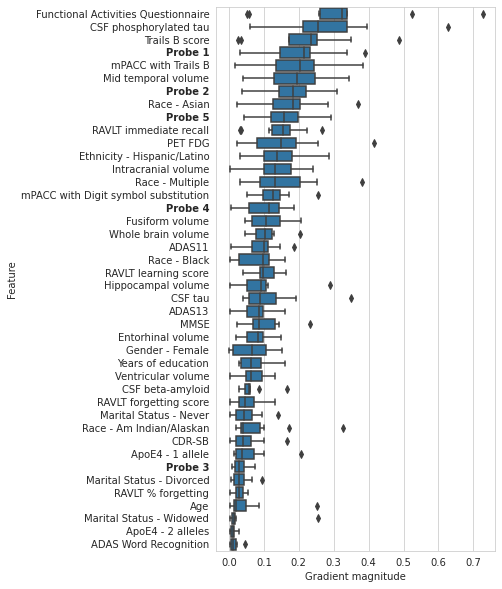

In [9]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.AUC(curve='PR', name='auprc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsBase, dfGradsBase = cross_validate(BaseMLP, evaluate_heldout_sites=True, compile_args=dictCompile)

lsSortOrder = dfGradsBase.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsBase, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax,
            color='C0')
ax.set_xlabel('Gradient magnitude')
for t in ax.get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

fig.savefig(os.path.join(strOutputDir, 'conventional.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'conventional.png'), bbox_inches='tight')

print(dfResultsBase.median())

## Using cluster as another input

AUROC                     0.894435
Accuracy                  0.870200
Youden's index            0.740399
F1                        0.759231
PPV                       0.640639
NPV                       0.971752
Sensitivity               0.936842
Specificity               0.809700
Val_AUROC                 0.897335
Val_Accuracy              0.780760
Val_Youden's index        0.561520
Val_F1                    0.666667
Val_PPV                   0.575188
Val_NPV                   0.913043
Val_Sensitivity           0.809091
Val_Specificity           0.785714
Heldout_AUROC             0.820202
Heldout_Accuracy          0.766798
Heldout_Youden's index    0.533596
Heldout_F1                0.714286
Heldout_PPV               0.687878
Heldout_NPV               0.846453
Heldout_Sensitivity       0.764228
Heldout_Specificity       0.789216
dtype: float64


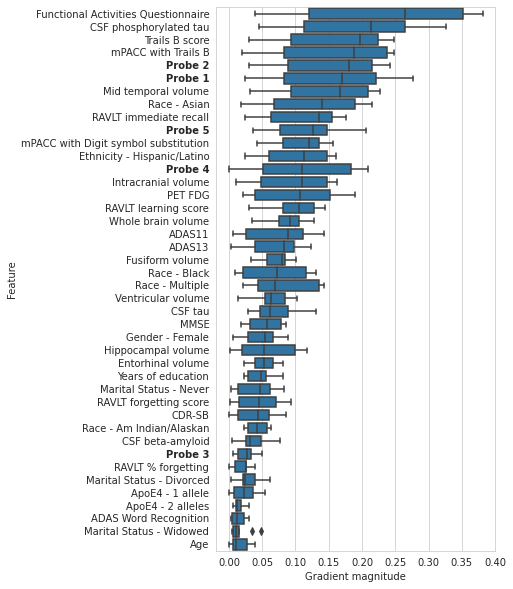

In [13]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.AUC(curve='PR', name='auprc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsConcat, dfGradsConcat = cross_validate(ClusterCovariateMLP, use_z=True, 
                                                evaluate_heldout_sites=True, compile_args=dictCompile)

lsSortOrder = dfGradsConcat.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsConcat, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax,
            color='C0')
ax.set_xlabel('Gradient magnitude')
for t in ax.get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

fig.savefig(os.path.join(strOutputDir, 'clusterinput.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'clusterinput.png'), bbox_inches='tight')

print(dfResultsConcat.median())

## Domain adversarial model

/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUROC                     0.777053
Accuracy                  0.742344
Youden's index            0.484689
F1                        0.614833
PPV                       0.546066
NPV                       0.874849
Sensitivity               0.696382
Specificity               0.774319
Val_AUROC                 0.773382
Val_Accuracy              0.718025
Val_Youden's index        0.436050
Val_F1                    0.572158
Val_PPV                   0.522727
Val_NPV                   0.859606
Val_Sensitivity           0.636364
Val_Specificity           0.821429
Heldout_AUROC             0.669008
Heldout_Accuracy          0.535360
Heldout_Youden's index    0.070720
Heldout_F1                0.132945
Heldout_PPV               0.875758
Heldout_NPV               0.641110
Heldout_Sensitivity       0.073171
Heldout_Specificity       0.997549
dtype: float64


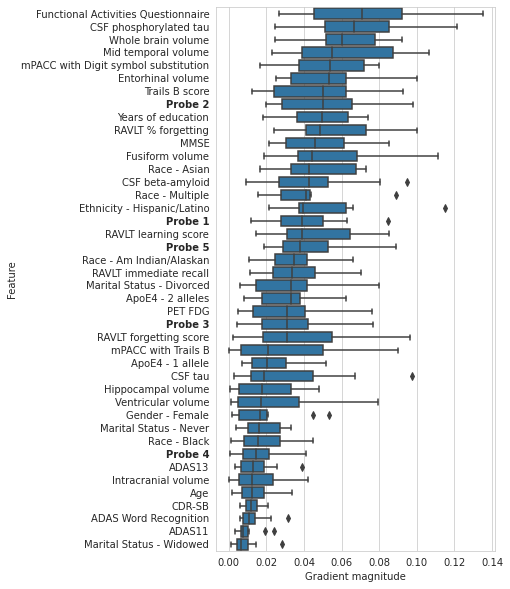

In [11]:
dictBuild = {'n_clusters': kfolds.z.shape[1], 'adversary_layer_units': [8, 8, 4]}
dictCompile = {'loss_gen_weight': 10.0}
dfResultsDA, dfGradsDA = cross_validate(DomainAdversarialMLP, use_z=True, evaluate_heldout_sites=True,
                                        build_args=dictBuild, compile_args=dictCompile)

lsSortOrder = dfGradsDA.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsDA, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax, 
            color='C0')
ax.set_xlabel('Gradient magnitude')
for t in ax.get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')
        
fig.savefig(os.path.join(strOutputDir, 'domainadversarial.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'domainadversarial.png'), bbox_inches='tight')
        
print(dfResultsDA.median())

## Mixed effects model

AUROC                     0.950857
Accuracy                  0.893965
Youden's index            0.787929
F1                        0.810207
PPV                       0.753149
NPV                       0.961948
Sensitivity               0.905263
Specificity               0.889105
Val_AUROC                 0.912965
Val_Accuracy              0.788793
Val_Youden's index        0.577586
Val_F1                    0.666667
Val_PPV                   0.625874
Val_NPV                   0.906429
Val_Sensitivity           0.763636
Val_Specificity           0.821429
Heldout_AUROC             0.820540
Heldout_Accuracy          0.692372
Heldout_Youden's index    0.384744
Heldout_F1                0.649062
Heldout_PPV               0.538842
Heldout_NPV               0.893751
Heldout_Sensitivity       0.890244
Heldout_Specificity       0.558824
dtype: float64


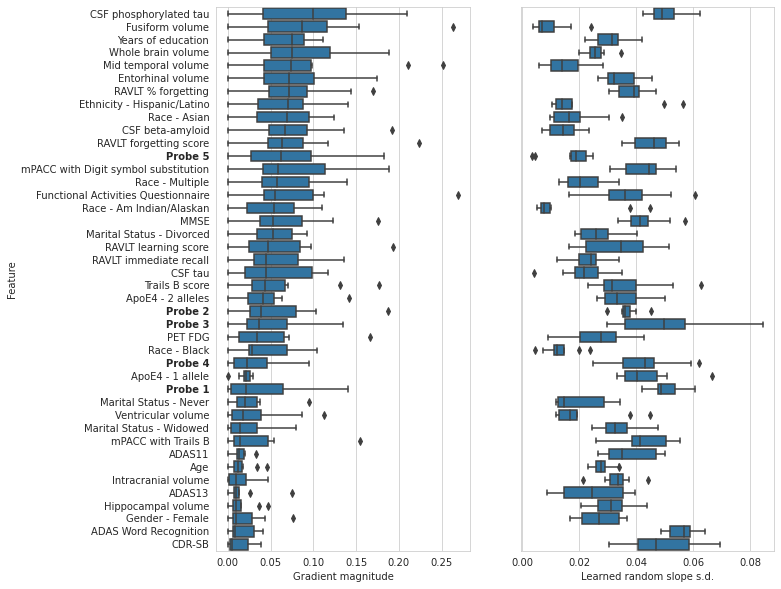

In [12]:
dictBuild = {'n_features': kfolds.x.shape[1],
             'n_clusters': kfolds.z.shape[1],
             'adversary_layer_units': [8, 8, 4],
             'slope_posterior_init_scale': 0.1, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.15, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.001}
dictCompile = {'loss_class_fe_weight': 1.0, 'loss_gen_weight': 20., 'loss_class_me_weight': 1.0}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept = cross_validate(MixedEffectsMLP,  
                                                                            use_z=True, 
                                                                            evaluate_heldout_sites=True,
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
lsSortOrder = dfGradsME.groupby('Feature').median().sort_values('Gradient', ascending=False).index
sns.boxplot(data=dfGradsME, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax[0], color='C0')
sns.boxplot(data=dfRandomSlopeSD, x='S.D.', y='Feature', orient='h', order=lsSortOrder, ax=ax[1], color='C0')
ax[0].set_xlabel('Gradient magnitude')
for t in ax[0].get_yticklabels():
    if 'Probe' in t.get_text():
        t.set_fontweight('bold')

ax[1].set_ylabel(None)
ax[1].set_xlabel('Learned random slope s.d.')

fig.savefig(os.path.join(strOutputDir, 'mixedeffects.svg'), bbox_inches='tight')
fig.savefig(os.path.join(strOutputDir, 'mixedeffects.png'), bbox_inches='tight')

print(dfResultsME.median())